In [17]:
!pip install gdown

# Unduh file dari Google Drive
!gdown --id 1iePr-95ohkXLcgaXBEWNYb2R3lu_-pjz -O daily-min-temperatures.csv


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iePr-95ohkXLcgaXBEWNYb2R3lu_-pjz
To: /content/daily-min-temperatures.csv
100% 67.9k/67.9k [00:00<00:00, 68.5MB/s]


Missing values: 0


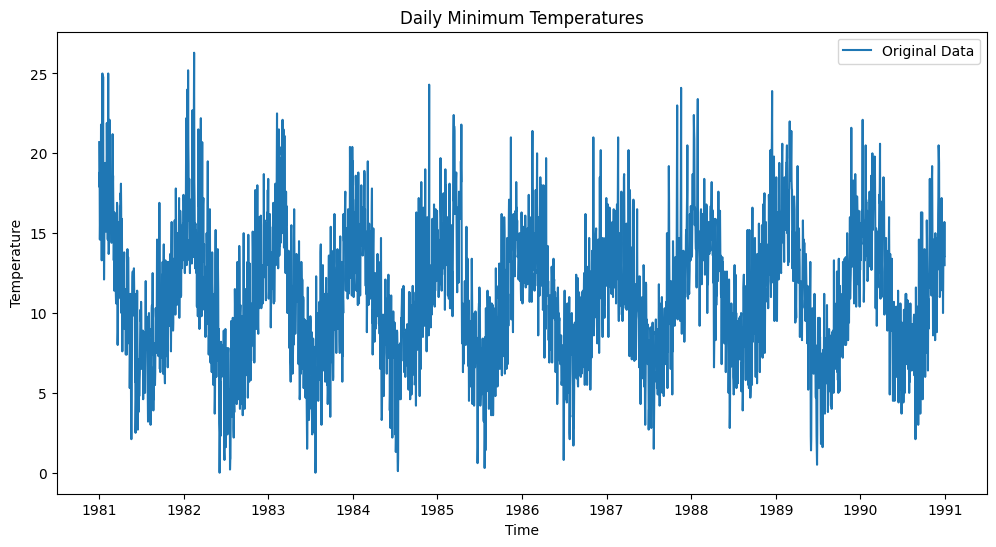

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Load dataset
data = pd.read_csv("daily-min-temperatures.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Check for missing values
print("Missing values:", data.isna().sum().sum())

# Normalisasi data
data['Temp_normalized'] = (data['Temp'] - data['Temp'].min()) / (data['Temp'].max() - data['Temp'].min())

# Plot data asli
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temp'], label='Original Data')
plt.title("Daily Minimum Temperatures")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()

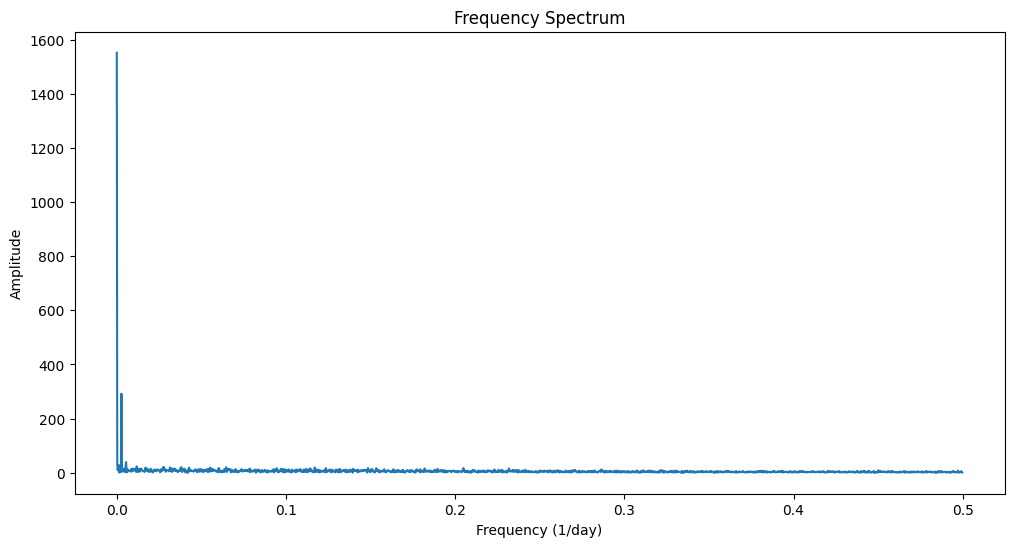

In [19]:
from scipy.fft import fft, fftfreq

# Transformasi Fourier
temp_fft = fft(data['Temp_normalized'].values)
frequencies = fftfreq(len(data), d=1)  # d=1 karena data harian

# Hanya ambil setengah spektrum (positif)
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft = abs(temp_fft[:len(temp_fft)//2])

# Plot spektrum frekuensi
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, positive_fft)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Amplitude")
plt.show()


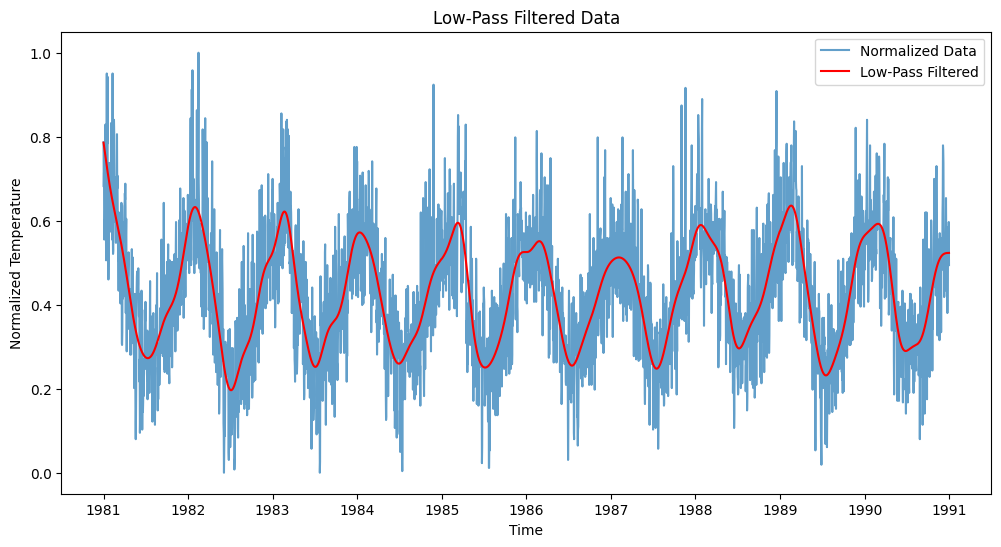

In [20]:
from scipy.signal import butter, filtfilt

# Fungsi low-pass filter
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Frekuensi Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Filter data
cutoff_frequency = 0.01  # Frekuensi cutoff (1/day)
filtered_temp = low_pass_filter(data['Temp_normalized'], cutoff=cutoff_frequency, fs=1)

# Plot data asli dan hasil filter
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temp_normalized'], label='Normalized Data', alpha=0.7)
plt.plot(data.index, filtered_temp, label='Low-Pass Filtered', color='red')
plt.title("Low-Pass Filtered Data")
plt.xlabel("Time")
plt.ylabel("Normalized Temperature")
plt.legend()
plt.show()


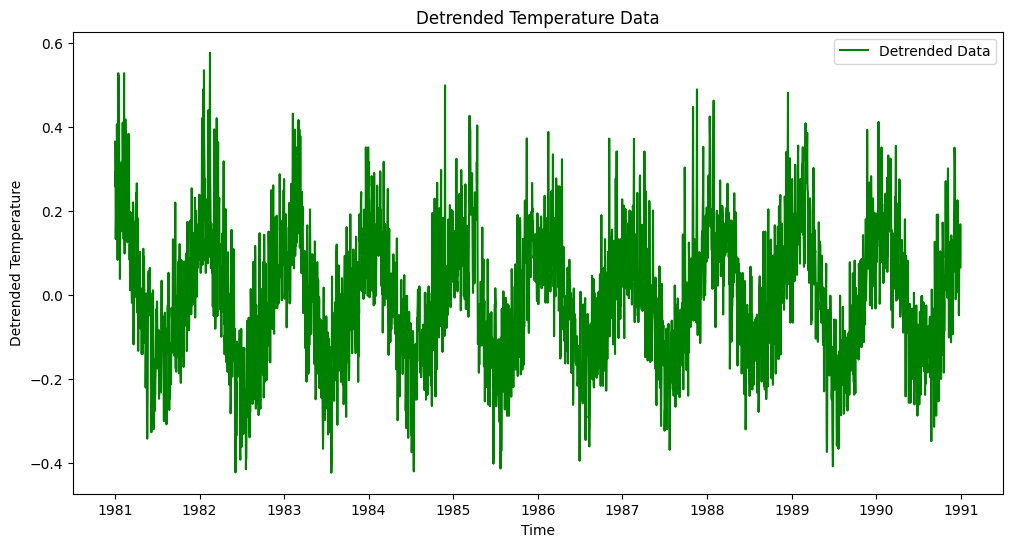

In [21]:
# Detrend data untuk analisis fluktuasi
detrended_temp = detrend(data['Temp_normalized'].values)

# Plot data detrended
plt.figure(figsize=(12, 6))
plt.plot(data.index, detrended_temp, label='Detrended Data', color='green')
plt.title("Detrended Temperature Data")
plt.xlabel("Time")
plt.ylabel("Detrended Temperature")
plt.legend()
plt.show()


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['Temp_scaled'] = scaler.fit_transform(data[['Temp']])

In [23]:
data['Lag1'] = data['Temp_scaled'].shift(1)
data['Lag2'] = data['Temp_scaled'].shift(2)
data.dropna(inplace=True)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [25]:
X = data[['Lag1', 'Lag2']].values
y = data['Temp_scaled'].values

In [26]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [27]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [28]:
# Bangun model LSTM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1372 - val_loss: 0.0121
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0108
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0094
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - val_loss: 0.0094
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0123 - val_loss: 0.0084
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - val_lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


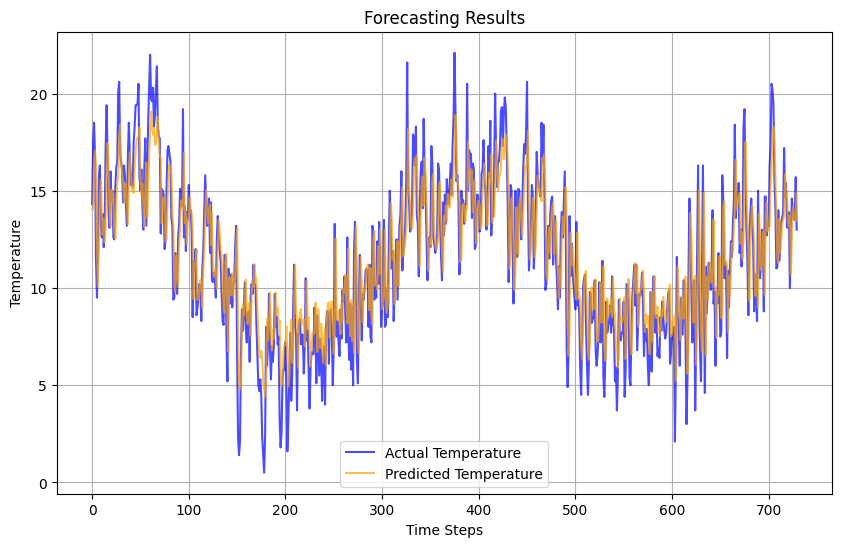

In [30]:
import matplotlib.pyplot as plt

# Prediksi pada data uji
y_pred = model.predict(X_test).flatten()

# Invers transformasi skala jika data awal telah dinormalisasi
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Temperature', color='blue', alpha=0.7)
plt.plot(y_pred_inverse, label='Predicted Temperature', color='orange', alpha=0.7)
plt.title('Forecasting Results')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import tensorflow as tf
import numpy as np

# Misalnya, y_true dan y_pred adalah nilai aktual dan prediksi
def r2_score_tf(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true)
    ss_total = tf.reduce_sum(tf.square(y_true - y_true_mean))
    ss_residual = tf.reduce_sum(tf.square(y_true - y_pred))
    r2 = 1 - (ss_residual / ss_total)
    return r2

def rmse_tf(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [32]:
# Evaluasi
y_pred = model.predict(X_test).flatten()

# Hitung metrik
y_test = tf.constant(y_test, dtype=tf.float32)
y_pred = tf.constant(y_pred, dtype=tf.float32)

r2 = r2_score_tf(y_test, y_pred)
rmse = rmse_tf(y_test, y_pred)

print(f"R² Score: {r2.numpy():.4f}")
print(f"RMSE: {rmse.numpy():.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R² Score: 0.6709
RMSE: 0.0895
